[58.0]
Point(coordinates=array([1.98386609e+02, 5.00062956e+01, 1.26652765e+05]))


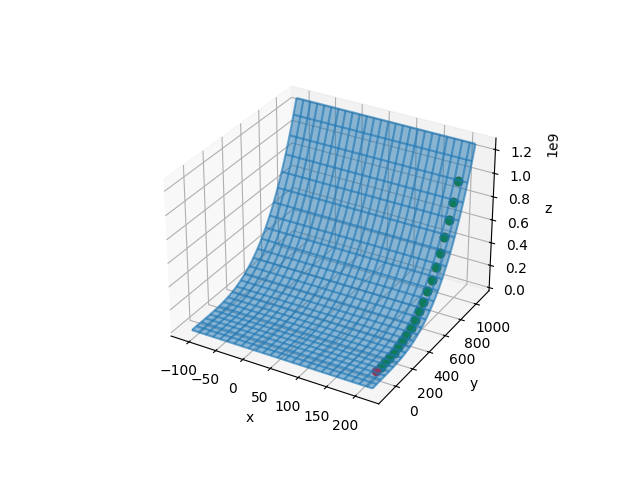

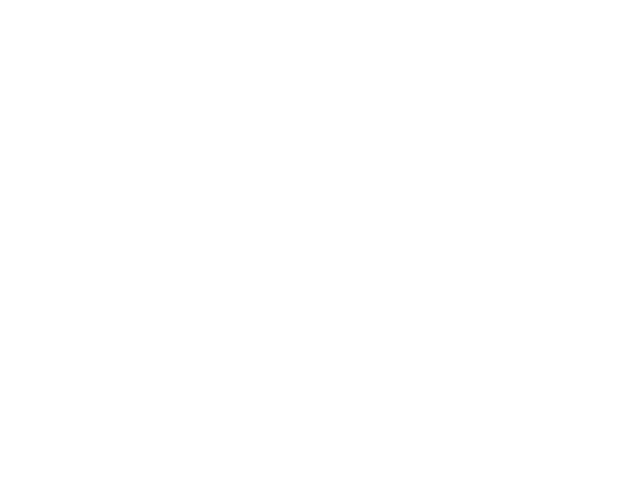

In [1]:
%matplotlib widget
from src.metric import CallCount
from src.common.oracul import LambdaOracul, PoweredSumOracul, GradientLambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import RandomMethod, GoldenRatioMethod, GradientDescent, BaseGradientDescent

import matplotlib.pyplot as plt

fig = plt.figure()

method = RandomMethod()
golden_ratio = GoldenRatioMethod()
gradient_descent = GradientDescent()
oracul = LambdaOracul(lambda x: (x - 10) ** 2)
test_oracul = PoweredSumOracul([[2, 2], [0, 2]])
gradient_oracul= GradientLambdaOracul(lambda x, y: (x-10)**2+(y-5)**3, lambda x, y: np.array([2*(x-10), 3*(y-5)**2],dtype=np.float64))
point, metrics, anim = MethodProcessor.process(gradient_descent, gradient_oracul, CountCondition(20), metrics=[CallCount()], method_params = {"x":np.array([200, 1000]), 'learning_rate':100}, visualize=True,
                                               low_bracket=[-100, -100], high_bracket=[200, 200])
print(metrics)
print(point)
plt.show()

[20.0]
Point(coordinates=array([1.98386609e+02, 5.00062956e+01, 1.26652765e+05]))


/home/mike/Documents/Methods-of-optimization/venv/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


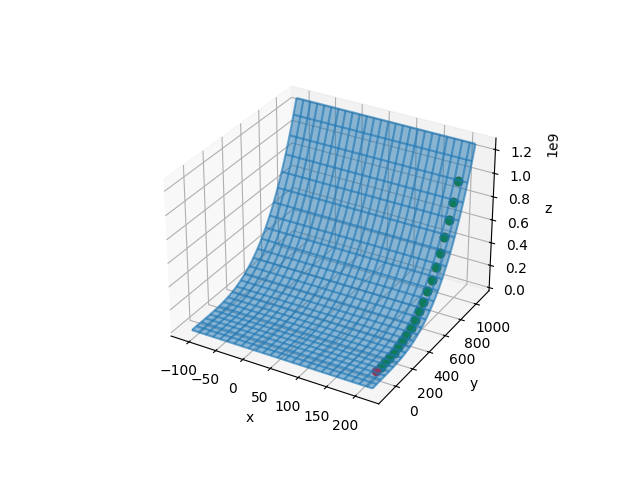

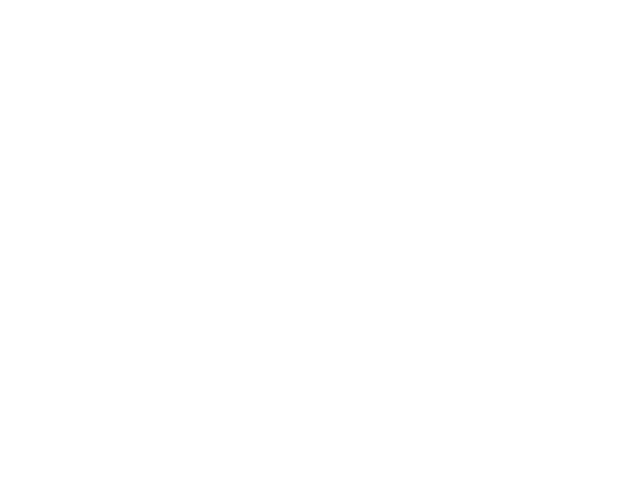

In [2]:
%matplotlib widget
from src.lab1.methods import DichotomyMethod
from src.metric import CallCount
from src.common.oracul import LambdaOracul, PoweredSumOracul, GradientLambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import RandomMethod, GoldenRatioMethod, GradientDescent, BaseGradientDescent

import matplotlib.pyplot as plt
fig = plt.figure()

def f(x):
    return (1 + (x[0] + x[1] + 1)**2 * (19 - 14*x[0] + 3*x[0]**2-14*x[1]+6*x[0]*x[1]+3*x[1]**2)) * (30 + (2*x[0] - 3*x[1])**2 * (18 - 32*x[0] + 12*x[0]**2 + 48*x[1] - 36*x[0]*x[1]+27*x[1]**2))


gradient_descent = GradientDescent(method=DichotomyMethod())
gradient_oracul= GradientLambdaOracul(lambda x, y: (x-10)**2+(y-5)**3, lambda x, y: np.array([2*(x-10), 3*(y-5)**2],dtype=np.float64))
point, metrics, anim = MethodProcessor.process(gradient_descent, gradient_oracul, CountCondition(20), metrics=[CallCount()], method_params = {"x":np.array([200, 1000]), 'learning_rate':100}, visualize=True,
                                               low_bracket=[-100, -100], high_bracket=[200, 200])
print(metrics)
print(point)
plt.show()